# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle
# Import Module
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, run_scenario, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species
import libcbm

## Create and Run `ForestModel` instance

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

In [3]:
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=1)

display(hwp_pool_effect)

FloatSlider(value=1.0, description='HWP_effect', max=1.0, step=1.0)

In [4]:
hwp_pool_effect_value = hwp_pool_effect.value

In [5]:
# Here we indicate whether the harvested pool products turn into emissions immediately instead of turning into wood products.
if hwp_pool_effect_value == 0:
    release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=1)
    display(release_immediately)

In [6]:
if hwp_pool_effect_value == 0:
    release_immediately_value = release_immediately.value
else:  
    release_immediately_value = 0

In [7]:
if hwp_pool_effect_value != 0:
    displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1)
    display(displacement_effect)

FloatSlider(value=1.0, description='Displacement', max=1.0, step=1.0)

In [8]:
if hwp_pool_effect_value != 0:
    displacement_effect = displacement_effect.value
else:  
    displacement_effect = 0

In [9]:
if displacement_effect == 0:
   clt_percentage = 0
   credibility = 0
else:
    clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5)
    credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1)
    display(clt_percentage, credibility)

FloatSlider(value=0.5, description='CLT_percent:', max=1.0)

FloatSlider(value=1.0, description='Credibility:', max=1.0)

In [10]:
max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=0.1)
budget_input = widgets.FloatText(
    value=10000000,
    description='Budget:',
    disabled=False)
display(max_harvest, budget_input)

FloatSlider(value=0.1, description='Max_harvest:', max=1.0, step=0.05)

FloatText(value=10000000.0, description='Budget:')

In [11]:
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")
scenario_dropdown = widgets.Dropdown(
    options=['test', 'no_cons', 'bau_redchrs'],
    value='no_cons',
    description='Scenario:'
)
display(scenario_dropdown)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')

Dropdown(description='Scenario:', index=1, options=('test', 'no_cons', 'bau_redchrs'), value='no_cons')

In [12]:
def select_obj(obj_mode):
    print(f"Selected scenario: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='min_em',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Objective:', index=3, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='min_em')

In [13]:
if displacement_effect != 0:
    clt_percentage = clt_percentage.value
    credibility = credibility.value
max_harvest = max_harvest.value
budget_input = budget_input.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value

In [14]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            # model_path='./data/woodstock_model_files_redchris_test',
                            model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [15]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

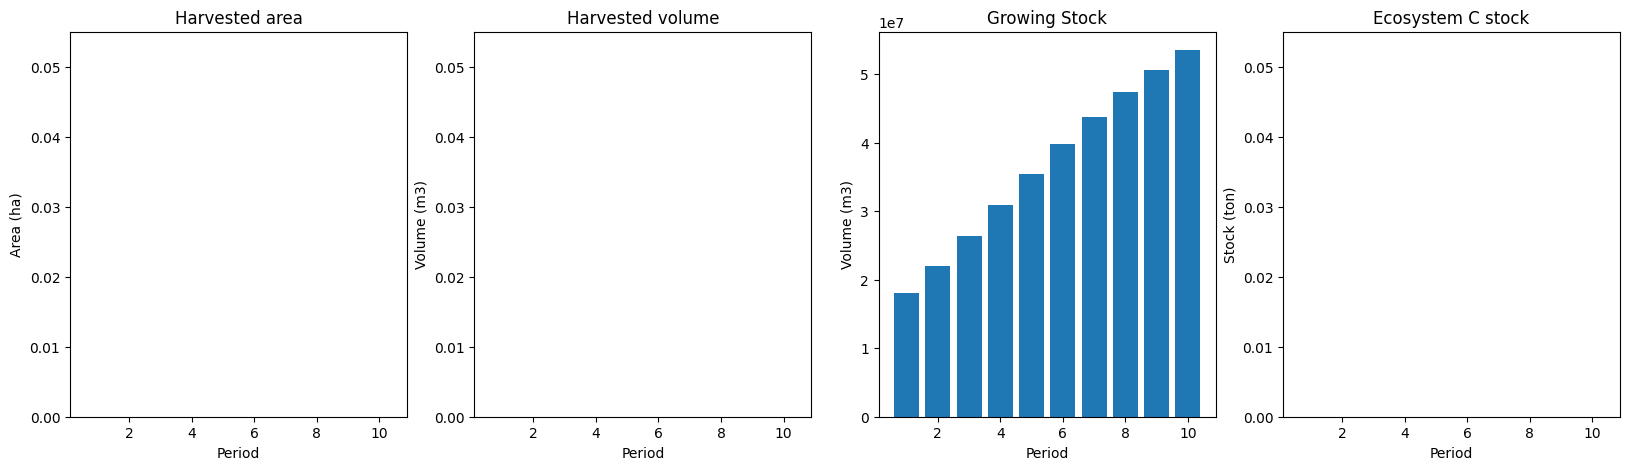

In [16]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [17]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [18]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [19]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [20]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [21]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]


npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

# decay_emissions_fluxes = [
#     'DecayVFastAGToAir',
#     'DecayVFastBGToAir',
#     'DecayFastAGToAir',
#     'DecayFastBGToAir',
#     'DecayMediumToAir',
#     'DecaySlowAGToAir',
#     'DecaySlowBGToAir',
#     'DecaySWStemSnagToAir',
#     'DecaySWBranchSnagToAir',
#     'DecayHWStemSnagToAir',
#     'DecayHWBranchSnagToAir'
# ]
ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]
grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']
GrossGrowth_pools = [
    'DeltaBiomass_AG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'DeltaBiomass_BG',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput']

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [22]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
# fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
# gross_growth = grossgrowth_ag + grossgrowth_bg
fluxes = ecosystem_decay_emissions_pools
gross_growth = GrossGrowth_pools
sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,1.403745e+07,3.874220e+07,5.277965e+07,0.000000e+00,0.000000e+00,0.000000
1,1.423830e+07,3.863534e+07,5.287364e+07,8.850461e+05,9.790345e+05,-93988.459640
2,1.443963e+07,3.854026e+07,5.297989e+07,8.807935e+05,9.870460e+05,-106252.503460
3,1.464088e+07,3.845560e+07,5.309648e+07,8.778403e+05,9.944342e+05,-116593.865791
4,1.484254e+07,3.838034e+07,5.322289e+07,8.758588e+05,1.002263e+06,-126404.196888
...,...,...,...,...,...,...
96,2.990867e+07,4.437639e+07,7.428506e+07,1.161644e+06,1.352158e+06,-190514.038495
97,2.999184e+07,4.448176e+07,7.447360e+07,1.164035e+06,1.352573e+06,-188538.465314
98,3.007064e+07,4.458672e+07,7.465736e+07,1.166360e+06,1.350117e+06,-183756.250185


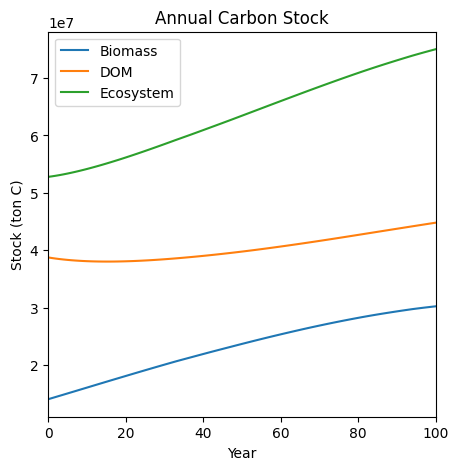

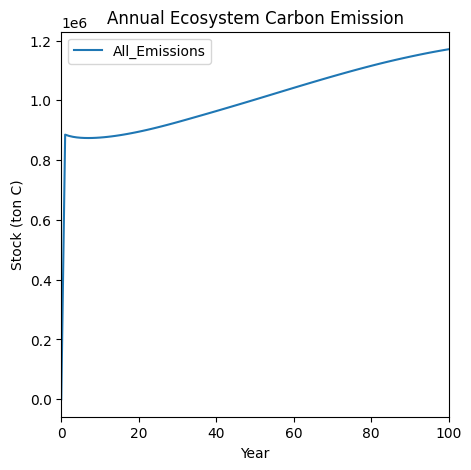

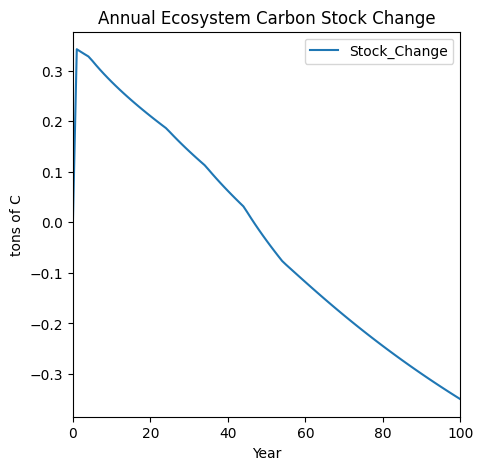

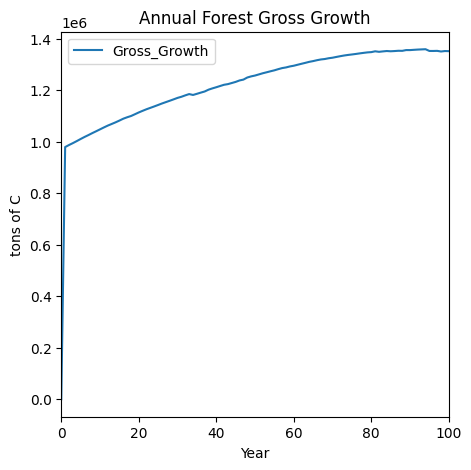

In [23]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Plug-in Carbon Yield Curves

In [24]:
# Read curves
# c_curves_p = pd.read_pickle("./redchris_c_curves_p_test.pkl")
# c_curves_f = pd.read_pickle("./redchris_c_curves_f_test.pkl")

c_curves_p = pd.read_pickle("./redchris_c_curves_p.pkl")
c_curves_f = pd.read_pickle("./redchris_c_curves_f.pkl")

In [25]:
# In order to reduce the impact of DOM input
# c_curves_p.loc[:59, 'DOM'] = c_curves_p.loc[:59, 'DOM'] * 0.1
# c_curves_p['ecosystem'] = c_curves_p['DOM'] + c_curves_p['biomass']

In [26]:
# Plug carbon yield curves into forest model
# plugin_c_curves(fm, c_curves_p, pools=sum_pools)
plugin_c_curves_both(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_emissions', 'total_emissions', 'gross_growth'])

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19', '19')
found match for mask ('?', '?', '?', '?', '20', '20')
found match for mask ('?', '?', '?', '?', '21', '21')
found match for mask ('?', '?', '?', '?', '22'

In [27]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7fec4a6a3bb0>),
   ('ecosystem', <ws3.core.Curve at 0x7fec3c4021a0>),
   ('biomass', <ws3.core.Curve at 0x7fec3c402230>),
   ('DOM', <ws3.core.Curve at 0x7fec3c402740>),
   ('net_emissions', <ws3.core.Curve at 0x7fec3c402590>),
   ('total_emissions', <ws3.core.Curve at 0x7fec3c400eb0>),
   ('gross_growth', <ws3.core.Curve at 0x7fec3c402140>),
   ('ecosystem', <ws3.core.Curve at 0x7fec3c4021a0>),
   ('biomass', <ws3.core.Curve at 0x7fec3c402230>),
   ('DOM', <ws3.core.Curve at 0x7fec3c402740>),
   ('net_emissions', <ws3.core.Curve at 0x7fec3c402590>),
   ('total_emissions', <ws3.core.Curve at 0x7fec3c400eb0>),
   ('gross_growth', <ws3.core.Curve at 0x7fec3c402140>)]),
 (('?', '?', '?', '?', '1', '1'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7fec4a6a3be0>),
   ('ecosystem', <ws3.core.Curve at 0x7fec3c400820>),
   ('biomass', <ws3.core.Curve at 0x7fec3c400730>),
   ('DOM'

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

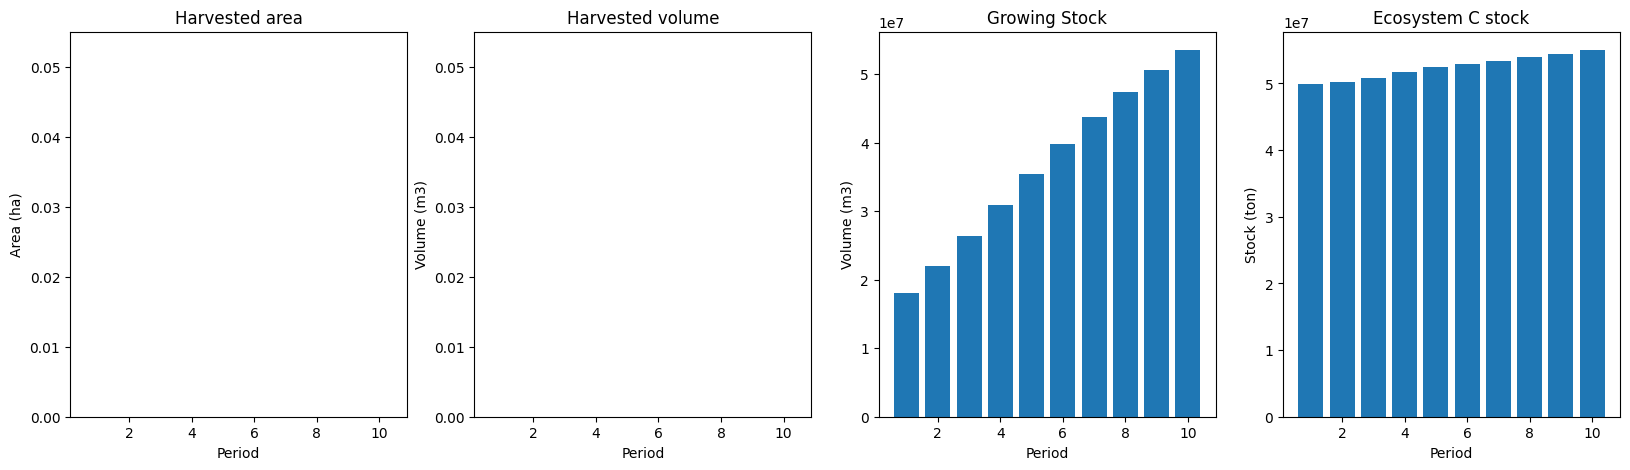

In [28]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## No-harvest

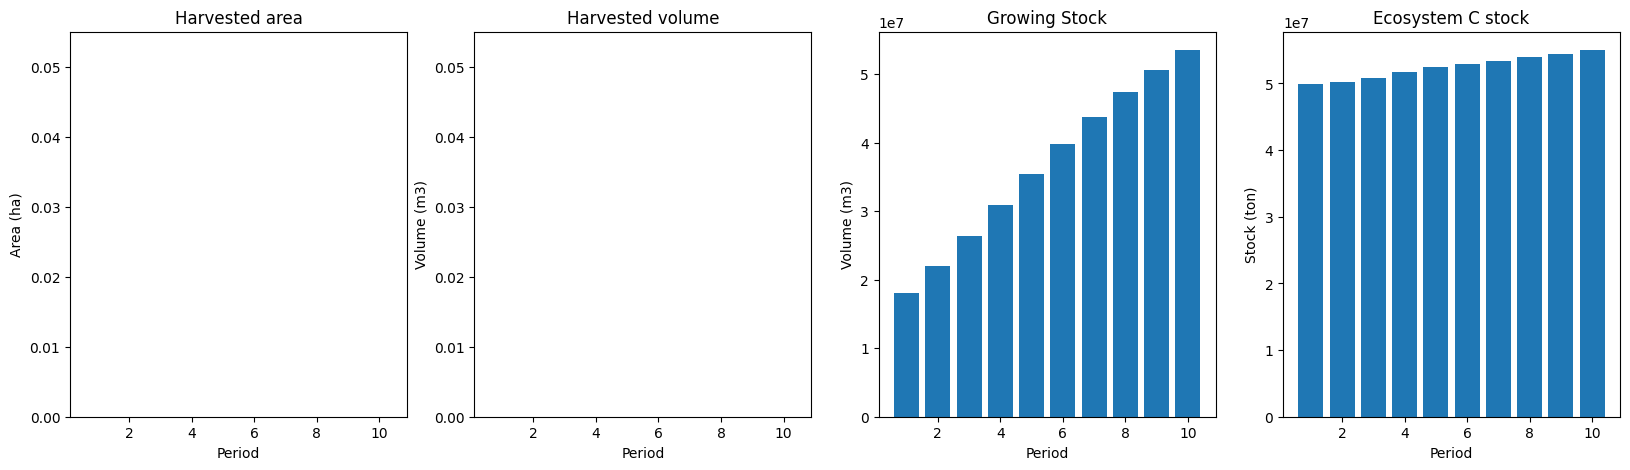

In [29]:
df = compile_scenario_maxstock(fm)
fig, ax = plot_scenario_maxstock(df)

In [30]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [31]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [32]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [33]:
sit_events

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)
cbm_report_both(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='whole')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="whole")

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='individual')
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="individual")

## Maximize the Total System Carbon Stock and Minimze Net Carbon Emission

In [ ]:
# def select_obj(obj_mode):
#     print(f"Selected scenario: {obj_mode}")
# obj_dropdown = widgets.Dropdown(
#     options=['max_hv', 'min_ha', 'max_st', 'min_em'],
#     value='min_em',
#     description='Objective:'
# )
# display(obj_dropdown)
# obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

In [ ]:
# obj_mode = obj_dropdown.value

In [ ]:
from util_opt import cmp_c_ss, cmp_c_se

In [ ]:
# Maximize Harvest
# run_scenario(fm, obj_mode , 'no_cons', solver='gurobi')
# run_scenario(fm, obj_mode , 'no_cons') #using pulp

In [ ]:
# Maximize Harvest
run_scenario(fm, obj_mode , 'no_cons', solver='gurobi')
# run_scenario(fm, obj_mode , 'no_cons') #using pulp

In [ ]:
# fm.applied_actions

In [ ]:
track_system_stock(fm)

In [ ]:
track_system_emission(fm)

In [ ]:
kpi_age(fm, case_study, obj_mode)

In [ ]:
kpi_species(fm, case_study, obj_mode)